In [2]:
# IMPORTS
from tqdm.notebook import tqdm
import json
import re
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
import pickle
import numpy as np 
from sklearn.cluster import DBSCAN
import statistics

In [7]:
# functions ---------------

# open file paths from txt
def opener(file):
    with open(file, 'r') as f:
        open_file = f.read().split('\n')
    return open_file

# get yandex json paths from imgs paths
def get_yandex_json_path(img_paths):
    yandjson_path_list =  []
    for i in img_paths:
        nomad = i.split('/')
        # print(len(nomad))
        # print(nomad)
        if len(nomad) == 7:
            yandex_str = nomad[5] + '_yandex_ocr'
            yandex_str_2 = nomad[6] + '.json'
            final_json_path = str('/' + nomad[1] + '/' + nomad[2] + 
                                '/' + nomad[3] + '/' + nomad[4] +
                                '/' + yandex_str + '/' + yandex_str_2)
            yandjson_path_list.append(final_json_path)
        if len(nomad) == 8:
            yandex_str = nomad[5] + '_yandex_ocr'
            yandex_str_2 = nomad[7] + '.json'
            final_json_path = str('/' + nomad[1] + '/' + nomad[2] + 
                                '/' + nomad[3] + '/' + nomad[4] + '/' + yandex_str +
                                '/' + nomad[6] + '/' + yandex_str_2)
            yandjson_path_list.append(final_json_path)
        if len(nomad) == 9:
            yandex_str = nomad[5] + '_yandex_ocr'
            yandex_str_2 = nomad[8] + '.json'
            final_json_path = str('/' + nomad[1] + '/' + nomad[2] + 
                                '/' + nomad[3] + '/' + nomad[4] + '/' + yandex_str +
                                '/' + nomad[6] + '/' + nomad[7] + '/' + yandex_str_2)
            yandjson_path_list.append(final_json_path)
    return yandjson_path_list

# PARSING JSON WITH WORDS AND COORDS
def parsed_yandex(yandex_ocr_json_path):
    try:
        with open(yandex_ocr_json_path, "r", encoding = 'utf-8') as f:
            data = f.read()
            parsed_yandex = json.loads(data)
    except Exception as e:
                    with open('logs_opened_json.log', 'a', encoding = 'utf-8') as f:
                        f.write(f'{e}\n')
    try:
        word_info = []
        for block in parsed_yandex['result']['results'][0]['results'][0]['textDetection']['pages'][0]['blocks']:
            for line in block['lines']:
                for word_payload in line['words']:
                    # print(word_payload)
                    text = word_payload['text']
                    vertices = word_payload['boundingBox']['vertices']
                    word_coord = (int(vertices[0]['x']), int(vertices[0]['y']), int(vertices[2]['x']), int(vertices[2]['y']))
                    word_info.append((word_coord, text))
    except Exception as e:
                    with open('logs_parsed_json.log', 'a', encoding = 'utf-8') as f:
                        f.write(f'{e}\n')
    return word_info

# get clusters of every unique line of text with coordinates x and y -------------------------------------
def get_coord_clusters(w_list):
    w_list.sort(key = lambda x: x[1])
    diff = [w_list[i+1][1] - w_list[i][1] for i in range(len(w_list) - 1)]
    n = []
    for x in diff:
        # if x>1:
        n.append(x)
    # print(diff)
    avg = sum(n) / len(n)
    # print(avg) #coefficient
    m = [[w_list[0]]]

    for row, x in enumerate(w_list[1:]): 
        # diff = [w_list[row+1][1] - w_list[row][1] for i in range(200)]
        # avg = sum(diff) / len(diff)
        avg3 = avg * 0.642
        if x[1] - m[-1][-1][1] < avg + avg3:
            m[-1].append(x)
        else:
            m.append([x])
    return m

# clustering function to find coordinates of the beginning and the end of every line and to get median values of these parameters
# median function doesn't work if images are not aligned and the page scan's tilt is very large (right or left)
# if your images has tilt, it's better to use 'min(test_list) / max(test_list)'
def get_median(test_list):
    X = np.array(test_list).reshape(-1, 1)
    clustering = DBSCAN(eps=2, min_samples=3).fit(X)
    clust_list = (clustering.labels_).tolist()
    count = sorted([(clust_list.count(cluster), cluster) for cluster in set(clust_list)], reverse = True) #count clusters
    q = count[0][1] #value os the most frequent cluster
    data = []
    for coord, clust_num in zip(test_list, clust_list):
        if clust_num == q: #the biggest cluster in 'x min' list
            data.append(coord)
    # print(data)
    mediana = statistics.median(data)
    return int(mediana)


def get_all_min_x(m):
    all_x_min = [] #all min x on every page
    # all_x_max = []
    
    for row in m:
        row = list(row)
        row.sort(key = lambda k: k[2]) #sort on x
        temp = ''
        row_x_list=[]
        
        for el in row:
            *w,yc,xc, = el
            row_x_list.append(xc)
        # print(row_x_list)   
        x_row_min = min(row_x_list)  #minimal x of every line 
        # x_row_max = max(row_x_list) #maximal x of every line
        all_x_min.append(x_row_min)
    return all_x_min

def get_all_max_x(m):
    all_x_max = [] #all max x on every page
    
    for row in m:
        row = list(row)
        row.sort(key = lambda k: k[2]) #sort on x
        temp = ''
        row_x_list=[]
        
        for el in row:
            *w,yc,xc, = el
            row_x_list.append(xc)
        # print(row_x_list)   
        x_row_max = max(row_x_list)  #maximal x of every line
        all_x_max.append(x_row_max)
    return all_x_max
    
# MAIN SORT CATEGORY FUNCTION--------------------------------!
# ----------------auxiliary line markup ------------------------
# Line linked with text block (one bibliographic record): -----> 
# header: HEADER 
# Numbers of UDC/LBC on separate lines (+ 50% from the beggining of the page): REG

def temp_f_2(m, x1_list, x2_list):
# def temp_f_2(m, mediana, x2_list):
    temp_blocks = []
    # x1min = get_median(x1_list) #absolute mediana x # left and right borders of text field of the page
    x1min = min(x1_list) #absolute min x
    # x1min = mediana
    x2max = max(x2_list) #absolute max x
    # x2max = mediana_2
    # print(x1min)
    # print(x2max)
    # print(x_min)
    # print(len(m))
    # print(len(x2_list))
    # print(len(x2_list))
    for row in m:
        row = list(row)
        row.sort(key = lambda k: k[2]) #sort on x
        temp = ''
        row_x_list=[]
        
        for el in row:
            *w,yc,xc,x2c = el
            if len(row) == 1:
                row_x_list.append(xc)
            else:
                row_x_list.append(xc)
        *w,yc,xc,x2c = row[-1]
        row_x_list.append(x2c)       
                
        # print(row_x_list)   
        x_row_min = min(row_x_list)  #min x of every line 
        x_row_max = max(row_x_list) #max x of every line 
        # print(len(row_x_list))
        
        #all min x on every page
        # print(all_x_min)
        # print(x_row_min)    
        
        for el in row:
            temp = temp + ' ' + el[0] #get the line from words
        # print(temp)
    #filtering on categories with auxiliary line markup
        if x_row_min > x1min + 50: #(x1min * 0.25): #* 0.642): #x1min + 60: 
        #new paragraphs markup and bigger then standart line beginning 
        # (headers, indents, Numbers of UDC/LBC and page numbers)
            # str_len = x2max - x_row_min #line lenght
            # print(f'Line Lenght {str_len}')
            # print(f'Min common x {x1min}')
            # print(f'Min x of line {x_row_min}')
            # print(f'Max x {x2max}')
            # print(f'Max x of line {x_row_max}')
#                 HEADLINES CONDITIONS
            if float(x_row_min) > x2max - (x2max * 0.95) and float(x_row_max) < x2max * 0.9:
                # print(f'HEADER {temp}')
                temp_blocks.append(f'HEADER {temp}')
#                 CONDITIONS OF NUMBERS OF UDC/LBC (ON THE LEFT SIDE OF PAGES)
            elif float(x_row_min) > x2max - (x2max * 0.6):
                # print(f'REG {temp}')
                if len(temp) <= 5:
                    temp_blocks.append(f'PAGE {temp}') #for page numbers with right alignment
                else:
                    temp_blocks.append(f'NUM {temp}')
            else:
                # print('----->'+ temp)
                temp_blocks.append(f'-----> {temp}')
        else:
            # print(temp)
            # temp_blocks.append(temp)
            if len(temp) <= 5:
                temp_blocks.append(f'PAGE {temp}') ##for page numbers with left alignment
            else:
                temp_blocks.append(temp)
    return temp_blocks

def get_uniqs(test_list):
    result_list = []
    pattern = r'(-{5}>  \d+-\d+ \. [А-ЯЁ])|(-{5}>  \d+-\d+ \. «[А-ЯЁ])|(-{5}>  \d+\. [А-ЯЁ])|(-{5}>  \d+\. «[А-ЯЁ])|(HEADER  )|(-{5}>  \d+\. [A-Z])'  
    # regular expression for every line with new paragraph, figure from point and upper letter
    combined_string = ''  # write the variable to concatenate strings until first match

    for string in test_list:
        if re.match(pattern, string):
            if combined_string:  # If there are previous rows, they are added to the result before the current row is added
                result_list.append(combined_string)
                combined_string = ''  # Reset combined_string for the next block of strings
            combined_string += string
        else:
            if combined_string:
                combined_string += ' $$$ ' + string  # Add a separator $$$ between the combined lines
            else:
                combined_string += string

    if combined_string:  # Add the remaining lines to the result
        result_list.append(combined_string)

    return result_list

In [95]:
# MAIN CODE FOR ALL PAGES 1959-1979
imgs_all = opener('your_img_paths_list.txt')
# print(len(imgs_all))
yandex_paths = get_yandex_json_path(imgs_all)
# print(len(yandex_paths))

196330
196330


In [ ]:
# MAIN CODE
start_time = time.time()
imgs = imgs_all #MAIN
length = len(yandex_paths)
# imgs = imgs_all[:300] #TEST

imgs_with_blocks = []

for img, yandex_ocr_json_path in tqdm(zip(imgs, yandex_paths), total = length):
    try:
        # yandex_ocr_json_path  = yandex_paths[0]
        y1_list = []
        x1_list = []
        x2_list = []
        word_list = []

        # count = collections.Counter()
        filter_y = []
        kf_s = []

        # get data from page with text
        word_info = parsed_yandex(yandex_ocr_json_path)
        # print(word_info)
        for w in word_info:
            # print(w)
            *coords,words_unit = w
            # print(words_unit)
            # print(words_unit)
            # print(coords[0][1])
            y1_list.append(coords[0][1])
            x1_list.append(coords[0][0])
            x2_list.append(coords[0][2])
            word_list.append(words_unit)
        # print(x1_list)
        # print(x2_list)
        metaword = list(zip(word_list, y1_list, x1_list, x2_list))
        # clustering coordinates with all x -> output == list of lists
        m = get_coord_clusters(metaword)
        # print(len(m))
        # print(m)
        # max coord in every line cluster on y
        # list_y_max = get_y1_max(m)
        all_min_x = get_all_min_x(m)
        # print(all_min_x)
        # all_max_x = get_all_max_x(m, x1_list, x2_list)
        mediana = get_median(all_min_x) #median of min x of line from the biggest cluster min x
        # print(mediana)
        # mediana_2 = get_median(all_max_x)
        # print(mediana_2)
        # temp_f(m, x1_list)
        # category_string_list = temp_f_2(m, x1_list, x2_list)
        category_string_list = temp_f_2(m, mediana, x2_list)
        # print(category_string_list)
        tuple_input = img, category_string_list
        imgs_with_blocks.append(tuple_input)
    except Exception as e:
        with open('block_split.log', 'a') as f:
            f.write(f'{img} | Error: {e}' +'\n')
try:
    uniq_list = [] #tuple list == (image filename, [text blocks list and headers, where all lines wrote with separator $$$]) 
    for elem in imgs_with_blocks:
        block_list = get_uniqs(elem[1]) #sort all page lines to text blocks and headers
        uniq_list.append((elem[0], block_list))
except Exception as e:
    with open('block_split.log', 'a') as f:
        f.write(f'{img} | Error: {e}' +'\n')
        
end_time = time.time()
elapsed = end_time - start_time
# print(elapsed)

In [ ]:
# print(len(imgs_with_blocks))

In [98]:
# write file of results (uniq_list)
# with open('block_split_59_79.pickle', 'wb') as f:
#     pickle.dump(uniq_list, f)

In [ ]:
# TEST
# checking result
# print(len(uniq_list))

# blocks = []
# [blocks.extend(_[1]) for _ in uniq_list]
# len(blocks)

# len([_ for _ in blocks if _[:6] == '----->'])

In [110]:
# TEST
uniq_list[6][1]

['----->  47034. Ахалая Х. Рабочий класс Абхазии в период коммунистического $$$  строительства (1959-1965 гг.) Сухумн, «Алашара», 1971. 222 с. - Биб- $$$  лиогр. ссылки в подстроч. примеч. -- На груз. яз. --- 20 см. 2.000 экз. 86 к. $$$  В пер. -- [ 71-76843 ] п 321.914.1 (47 + 57) + 308 (479.224) + [016.3]',
 '----->  47035. Бегун Вл. Чего не видит турист. [Очерки о моральном облике $$$  белорусов]. Минск, 1971. 67 с. (Б-чка газ. «Голас Радзiмы»). - На бе- $$$  лорус. яз. - 15 см. 10 к. -- [ 71-68829 ] п 321.8 : 172 + 308 (476)',
 '----->  47036. Бурятия. [Фотоальбом. Фото А. Пономарева и др.] Улан- $$$  Удэ, Бурят. кн. изд-во, 1971. 4 с.; 46 л. ил. - 17×22 см. 25.000 экз. 2 р. 8 к. $$$  В пер. - [ 71-74137 ] п 308 (571.54) (084.121)',
 '----->  47037. Калюта Н. И. Краснознаменск. Калининград, Кн. изд-во, 1971. $$$  79 с. с ил. (Города нашей обл.) - На обл. авт. не указан. - -14 см. $$$  1.000 экз. 6 к. -- [ 71-76397 ] п 308(470.26-21K)',
 '----->  47038. На рубежах пятилетки. [Сборни

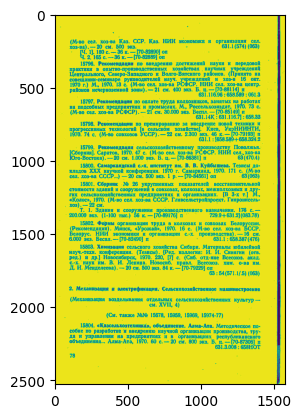

In [59]:
# TEST
# VIS OF SOME SAMPLES
im_path = 'your_img_path.jpg'
problem = cv2.imread(im_path, 0)
plt.imshow(problem)

In [283]:
# TEST
# sample image for visualization of coordinates
test_list_img = ['your_img1.jpg',
                 'your_img2.jpg',
                 'your_img3.jpg']
test_yandex_json = get_yandex_json_path(test_list_img)        

In [ ]:
# TEST
# visualization of Yandex-OCR coordinates
for yandex_ocr_json_path, img_path in tqdm(zip(test_yandex_json, test_list_img), total=length): 
    # print(yandex_ocr_json_path)
    # print(img_path)
    with open(yandex_ocr_json_path, "r") as f:
        data = f.read()
        # print(data)
        parsed_yandex = json.loads(data) 
        # print(parsed_yandex)
    # ________ get bbox coordinates of some words from json _______
    #     0 - left upper corner
    try:    
        word_info = []
        for block in parsed_yandex['result']['results'][0]['results'][0]['textDetection']['pages'][0]['blocks']:
            # print(block)
            for line in block['lines']:
                # print(line)
                for word_payload in line['words']:
                    # print(word_payload)
                    text = word_payload['text']
                    vertices = word_payload['boundingBox']['vertices']
                    word_coord = (int(vertices[0]['x']), int(vertices[0]['y']), int(vertices[2]['x']), int(vertices[2]['y']))
                    word_info.append((word_coord, text))
        # print(word_info) #list of bbox coords of single word (4 coords - x1, y1, x2, y2 and text string - one word)
        # print(word_info[0])
    except Exception as err:
        print('ERR')
        print(err)
    try:
        #use image filename
        im_yand = cv2.imread(img_path)
        for coord, str_ocr in word_info:
            # print(coord)
            vis_yandex = cv2.rectangle(im_yand, (coord[0], coord[1]), (coord[2], coord[3]), (255, 0, 255), 2)
        i = img_path.split('/') #your img path - sample './letopisi/1973/26/0040.jpg'
        # print(i)
        plt.imsave(f'your_forder/coords_vis/{i[4]}__{i[5]}__{i[6]}', vis_yandex)
        print('OK')    
    except Exception as err:
        print(err)